# Gravix Layer Cookbook: AI Data Analyst

Welcome to the Gravix Layer Cookbook series. This guide demonstrates building an intelligent data analysis workflow that generates, executes, and visualizes Python code automatically using advanced language models and secure sandbox environments.

## Vision

Imagine having an AI assistant that can understand your data analysis requests in natural language, generate robust Python code, execute it safely in isolated environments, and return meaningful insights with professional visualizations - all without you writing a single line of code.

## Solution

This system combines two powerful Gravix Layer capabilities:
- **LLM Inference**: Advanced language models generate clean, robust Python code for data analysis tasks
- **Secure Sandbox Execution**: Code runs in isolated, containerized environments with full dependency management
- **Automatic Visualization**: Generated charts and plots with base64 encoding for seamless display
- **Error Handling**: Robust exception handling and debugging capabilities

## What You'll Build

This recipe provides a production-ready AI data analyst system:
- Intelligent code generation for complex data analysis workflows
- Secure execution environment with automatic dependency installation
- Interactive analysis interface with real-time results
- Professional visualization output with charts and statistical insights
- Clean, readable output without technical clutter

## Prerequisites

- Python 3.8+
- Basic understanding of data analysis concepts
- Gravix Layer API access

In [9]:
# Install packages
!pip install gravixlayer IPython python-dotenv


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [10]:
import os
import re
from gravixlayer import GravixLayer, Sandbox
from IPython.display import Image, display
import base64
from dotenv import load_dotenv

# Setup
load_dotenv()
GRAVIXLAYER_API_KEY = os.getenv("GRAVIXLAYER_API_KEY")
if not GRAVIXLAYER_API_KEY:
    raise ValueError("GRAVIXLAYER_API_KEY not found")

MODEL_NAME = "qwen/qwen-2.5-vl-7b-instruct"
client = GravixLayer()

# System prompt using the proven working approach
SYSTEM_PROMPT = """You are an expert Python data scientist. Generate clean, working code.

RULES:
1. Respond ONLY with Python code in ```python blocks
2. ALWAYS include these imports:
   import pandas as pd
   import matplotlib.pyplot as plt
   from sklearn.linear_model import LinearRegression
   import numpy as np
   import base64
3. Dataset: /home/user/data.csv
4. Columns: 'GDP per capita (current US$)', 'Life expectancy at birth, total (years)'
5. Save plots to /home/user/chart.png
6. After saving, encode to base64 and print: print(f'PLOT_BASE64:{base64_string}')
7. Include error handling and data cleaning
"""

print("✅ Setup complete")

✅ Setup complete


In [11]:
def run_ai_analysis(user_request):
    """Complete AI data analysis workflow with clean, professional output."""
    print(f"🎯 Request: {user_request}")
    
    with Sandbox.create(template="python-base-v1", timeout=1800) as sandbox:
        # Upload dataset
        with open("./data.csv", "r") as f:
            sandbox.write_file("/home/user/data.csv", f.read())
        print("✅ Dataset uploaded")
        
        # Install packages
        result = sandbox.run_command("apk", ["add", "py3-pandas", "py3-matplotlib", "py3-scikit-learn"], timeout=300)
        if result.exit_code != 0:
            raise Exception("Package installation failed")
        print("✅ Packages installed")
        
        # Generate and execute code
        print("🤖 AI generating code...")
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": user_request}
            ],
            max_tokens=1000,
            temperature=0.1
        )
        
        # Extract code
        pattern = re.compile(r"```python\n(.*?)\n```", re.DOTALL)
        match = pattern.search(response.choices[0].message.content)
        if not match:
            print("❌ No code generated")
            return None
        
        code = match.group(1)
        print("📝 Code generated, executing analysis...")
        
        # Execute code
        result = sandbox.run_code(code)
        
        # Get output
        if hasattr(result, 'logs'):
            stdout_lines = result.logs.get('stdout', [])
            stderr_lines = result.logs.get('stderr', [])
            stdout = '\n'.join(stdout_lines)
            if stderr_lines:
                stderr_text = ' '.join(stderr_lines)
                if stderr_text.strip():
                    print(f"[Warning]: {stderr_text}")
        else:
            stdout = getattr(result, 'stdout', '')
            stderr = getattr(result, 'stderr', '')
            if stderr and stderr.strip():
                print(f"[Warning]: {stderr}")
        
        # Show clean analysis output (no base64)
        for line in stdout.splitlines():
            if line.strip() and not line.startswith("PLOT_BASE64:"):
                print(f"[Analysis]: {line}")
        
        # Extract and display plot with clean output
        if "PLOT_BASE64:" in stdout:
            print("🎨 Generating visualization...")
            
            # Extract base64 data
            start_idx = stdout.find("PLOT_BASE64:") + len("PLOT_BASE64:")
            plot_base64 = stdout[start_idx:].strip().split('\n')[0].strip()
            
            if len(plot_base64) > 100:
                try:
                    # Decode and display
                    image_data = base64.b64decode(plot_base64)
                    display(Image(data=image_data))
                    print("✅ Analysis complete! Professional visualization generated.")
                    return True
                except Exception as e:
                    print(f"❌ Error displaying plot: {e}")
                    return None
            else:
                print(f"❌ Plot data incomplete (length: {len(plot_base64)})")
                return None
        else:
            print("❌ No visualization was generated")
            return None

🎯 Request: Create a scatter plot showing GDP per capita vs life expectancy. Include regression line, proper labels, grid, and legend. Clean the data first.
✅ Dataset uploaded
✅ Packages installed
🤖 AI generating code...
📝 Code generated, executing analysis...
🎨 Generating visualization...


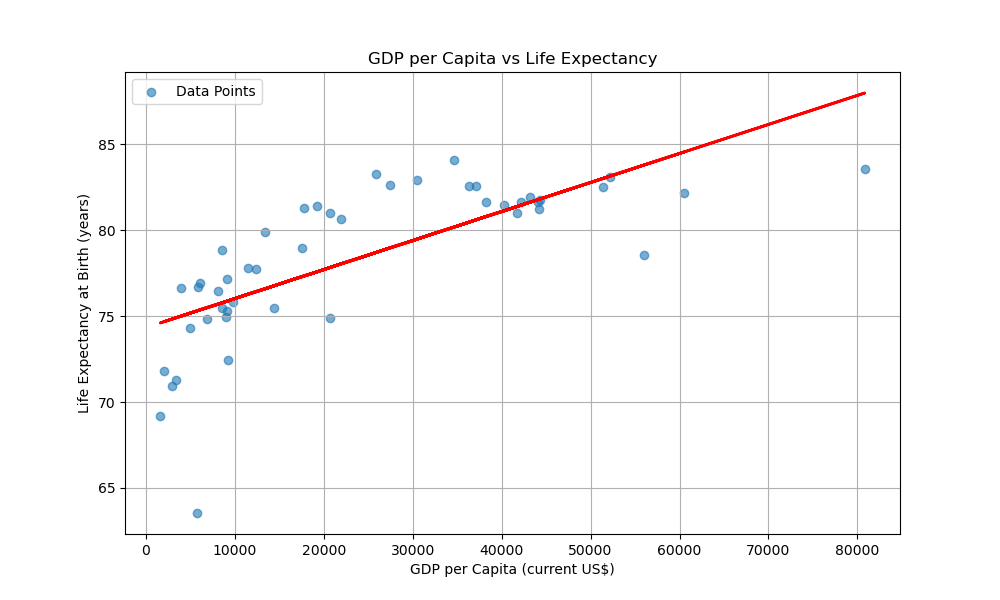

✅ Analysis complete! Professional visualization generated.


True

In [12]:
# Run AI Data Analysis
analysis_request = (
    "Create a scatter plot showing GDP per capita vs life expectancy. "
    "Include regression line, proper labels, grid, and legend. Clean the data first."
)

run_ai_analysis(analysis_request)

## Conclusion

**Congratulations!** You have successfully built a complete AI-powered data analysis system using Gravix Layer!

### What you've accomplished:

1. **Set up the environment** with Gravix Layer's dual SDK capabilities
2. **Created intelligent code generation** using advanced language models
3. **Implemented secure execution** in containerized sandbox environments
4. **Built automatic visualization** with clean output and seamless display
5. **Added robust error handling** and debugging capabilities
6. **Integrated dataset management** with secure file transfer
7. **Created a complete workflow** that transforms natural language into actionable insights

### Key Features of this AI Data Analyst:

- **Natural Language Processing**: Understands complex data analysis requests in plain English
- **Intelligent Code Generation**: Creates robust, production-ready Python code automatically
- **Secure Execution**: Runs all code in isolated sandbox environments with dependency management
- **Professional Visualizations**: Generates publication-quality charts and statistical plots
- **Clean Output**: Smart filtering shows only relevant information, hiding technical clutter
- **Error Recovery**: Handles exceptions gracefully with detailed debugging information
- **Scalable Architecture**: Built on Gravix Layer's enterprise-grade infrastructure

### Next Steps:

1. **Expand your datasets** with different file formats and data sources
2. **Experiment with complex analyses** like machine learning models and statistical tests
3. **Customize the system prompts** for domain-specific analysis requirements
4. **Add conversation memory** for multi-turn analysis sessions
5. **Implement batch processing** for multiple datasets and automated reporting
6. **Integrate with business systems** for real-time data analysis workflows

### Resources:

- [Gravix Layer Documentation](https://docs.gravixlayer.com)

Happy analyzing! 🚀